### Visualizing the distribution of the observations

### Load the required libraries

In [30]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBBBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib


C:\Users\kdhiman\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Circle', 'f', 'Rectangle', 'Polygon', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[3]) created by __init__ at <ipython-input-1-d02ac8b464b1>:13 

In [32]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [33]:
df2=df.groupby(['station','latitude','longitude','elevation']).agg({"station": "count"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(10)

,station,latitude,longitude,elevation,count(station)
130,US1MAES0003,42.8130,-71.1458,67.1,3
94,US1MAES0010,42.6483,-71.1728,47.9,1
122,US1MAES0012,42.6397,-70.9797,15.2,3
114,US1MEAN0021,43.9211,-70.1417,70.7,1
15,US1MECM0002,43.5920,-70.3440,17.1,1
170,US1MECM0003,43.9237,-70.2579,36.9,3
139,US1MECM0007,43.7440,-70.4890,44.8,9
121,US1MECM0008,43.7121,-70.2889,45.1,2
74,US1MECM0013,43.8324,-70.1200,62.5,6
149,US1MECM0015,43.8668,-70.1507,38.7,3


In [34]:
r = df2.collect()

In [107]:
counts = [x['count(station)'] for x in r]


In [89]:
df2.describe().show()

+-------+-----------+------------------+------------------+------------------+------------------+
|summary|    station|          latitude|         longitude|         elevation|    count(station)|
+-------+-----------+------------------+------------------+------------------+------------------+
|  count|        174|               174|               174|               174|               174|
|   mean|       null|           43.3991|-70.95568678160916|106.65862068965517| 69.12068965517241|
| stddev|       null|0.4244168847054999|0.5079490846520246|176.33000495604114|112.08297054515835|
|    min|US1MAES0003|           42.6397|            -71.65|            -999.9|                 1|
|    max|USW00094723|           44.0333|          -69.2622|            1813.9|               557|
+-------+-----------+------------------+------------------+------------------+------------------+



In [90]:
min_lat,max_lat,min_long,max_long = box = (42.6408, 44.0303, -71.65, -69.2622)

In [123]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(row['count(station)']/7+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color='red')
    circles.append(c)
    m.add_layer(c)
m    

### Select data for a particular station and measurement type

In [35]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMIN','USC00278612')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMIN' and station='USC00278612'
25 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    240.8|    43.9|    -71.3|       TMIN|USC00278612|    11|[80 D8 E0 D0 B0 D...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMIN|USC00278612|    12|[E0 D4 10 DA 10 D...|1976.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(25L, 365L)

### Script for plotting yearly plots

SELECT * FROM weather
	WHERE measurement='TMIN' and station='USC00278612'
25 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    240.8|    43.9|    -71.3|       TMIN|USC00278612|    11|[80 D8 E0 D0 B0 D...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMIN|USC00278612|    12|[E0 D4 10 DA 10 D...|1976.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00278612'
25 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------

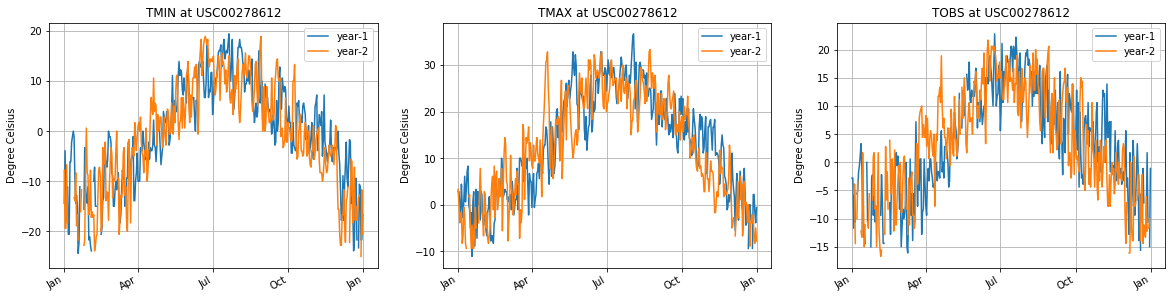

In [59]:
from YearPlotter import YearPlotter
fig,X=subplots(1,3,figsize=(20,5))
axes=X.reshape(3)
i=0
def plot_year(meas):
    global i
    sqlContext.registerDataFrameAsTable(df,'weather')
    Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%(meas,'USC00278612')
    print Query
    df1 = sqlContext.sql(Query)
    print df1.count(),'rows'
    df1.show(2)
    rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
    T=np.vstack(rows)
    if meas in ['TMIN','TMAX','TOBS','PRCP']:
        T=T/10.  # scaling to make the temperature be in centingrates
    shape(T)
    #fig, ax = plt.subplots(figsize=(10,7));
    YP=YearPlotter()
    YP.plot(T[:2,:].transpose(),fig,axes[i],title=meas+" at USC00278612",labels=['year-1','year-2'],axis_labels=['','Degree Celsius'])
    i+=1
    
plot_year('TMIN')
plot_year('TMAX')
plot_year('TOBS')

savefig("year_TMIN_TMAX_TOBS.png",bbox_inches='tight')
    
#title('A sample of graphs');

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00278612'
25 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    240.8|    43.9|    -71.3|       PRCP|USC00278612|     0|[00 53 00 00 00 0...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       PRCP|USC00278612|     4|[00 00 00 00 A0 5...|1976.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

SELECT * FROM weather
	WHERE measurement='SNOW' and station='USC00278612'
25 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------

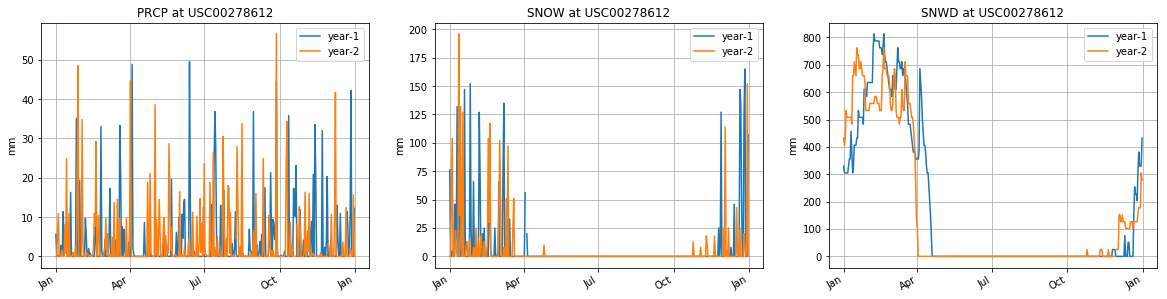

In [60]:
from YearPlotter import YearPlotter
fig,X=subplots(1,3,figsize=(20,5))
axes=X.reshape(3)
i=0
def plot_year(meas):
    global i
    sqlContext.registerDataFrameAsTable(df,'weather')
    Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%(meas,'USC00278612')
    print Query
    df1 = sqlContext.sql(Query)
    print df1.count(),'rows'
    df1.show(2)
    rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
    T=np.vstack(rows)
    if meas in ['TMIN','TMAX','TOBS','PRCP']:
        T=T/10.  # scaling to make the temperature be in centingrates
    shape(T)
    #fig, ax = plt.subplots(figsize=(10,7));
    YP=YearPlotter()
    YP.plot(T[:2,:].transpose(),fig,axes[i],title=meas+" at USC00278612",labels=['year-1','year-2'],axis_labels=['','mm'])
    i+=1
    
plot_year('PRCP')
plot_year('SNOW')
plot_year('SNWD')

savefig("year_PRCP_SNOW_SNWD.png",bbox_inches='tight')
    
#title('A sample of graphs');

In [37]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USC00278612')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
#T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='SNWD' and station='USC00278612'
25 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     0|[28 5D C4 5C C4 5...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       SNWD|USC00278612|     1|[C0 5E 58 5E C0 5...|1976.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(25L, 365L)

### Script for plotting yearly plots

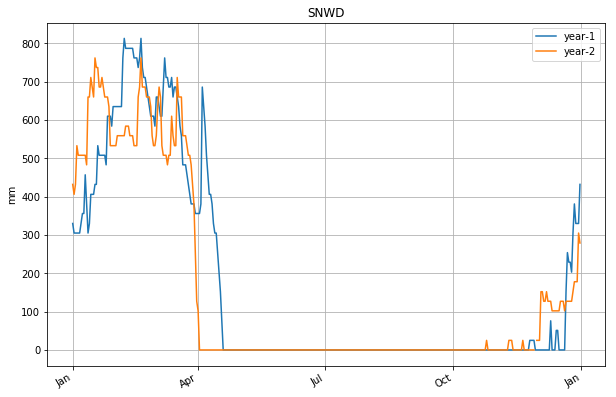

In [178]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='SNWD',labels=['year-1','year-2'],axis_labels=['','mm'])
savefig("year_SNWD.png",bbox_inches='tight')
#title('A sample of graphs');

In [179]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00278612')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00278612'
25 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    240.8|    43.9|    -71.3|       PRCP|USC00278612|     0|[00 53 00 00 00 0...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       PRCP|USC00278612|     4|[00 00 00 00 A0 5...|1976.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(25L, 365L)

### Script for plotting yearly plots

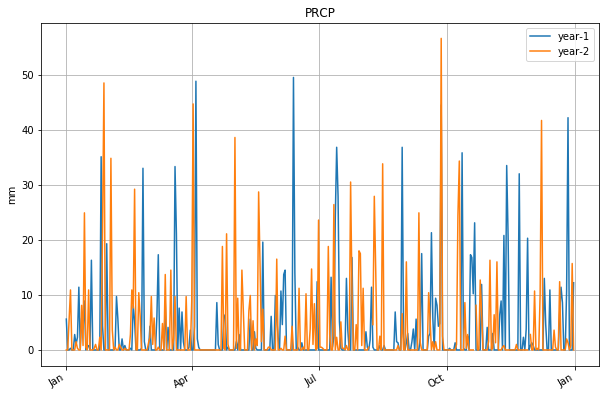

In [180]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP',labels=['year-1','year-2'],axis_labels=['','mm'])
savefig("year_PRCP.png")
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [8]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)

def plot_single(pair,func):
    j=0
    fig,X=subplots(1,1,figsize=(6,5))
    axes=X
    for m in pair:
        axis = axes
        j+=1
        func(m,fig,axis)

def plot_n(pair,func):
    n = len(pair)
    j=0
    fig,X=subplots(1,n,figsize=(48/n,12/n))
    axes=X.reshape(n)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)

def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

C:\Users\kdhiman\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


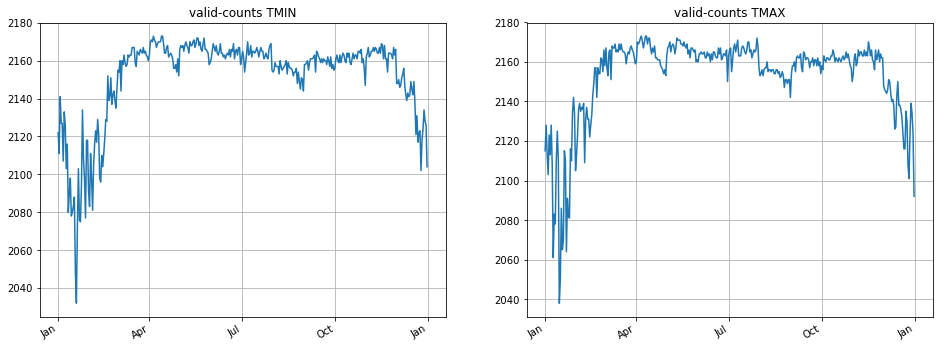

In [7]:
plot_pair(['TMIN','TMAX'],plot_valid)

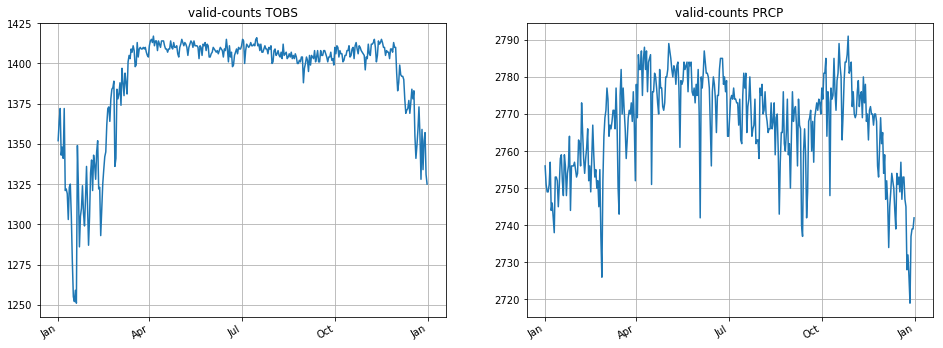

In [8]:
plot_pair(['TOBS','PRCP'],plot_valid)

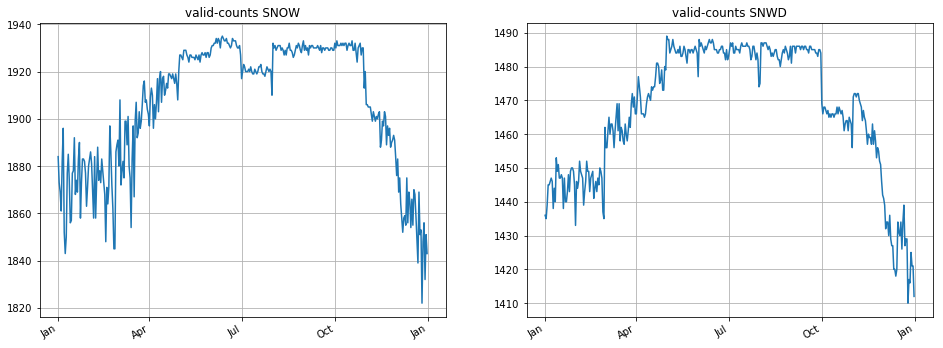

In [9]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [61]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    if m in ['TMIN','TMAX','TOBS','PRCP']:
        mean = mean / 10
        std = std / 10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m, labels=labels, axis_labels=axis_labels)

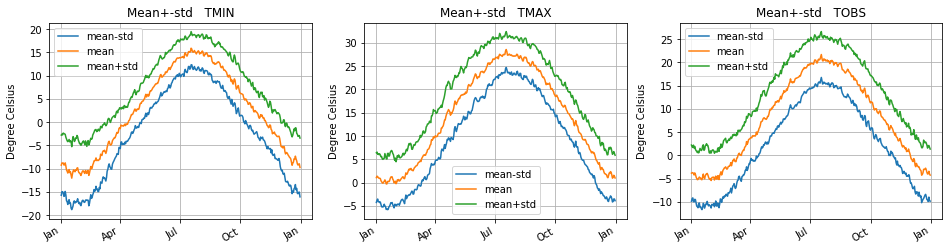

In [62]:
labels=['mean-std','mean','mean+std']
axis_labels=['','Degree Celsius']
plot_n(['TMIN','TMAX','TOBS'],plot_mean_std)
savefig("mean_std_TMIN_TMAX_TOBS.png",bbox_inches='tight')

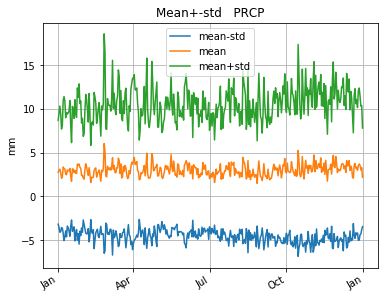

In [63]:
axis_labels=['','mm']
plot_single(['PRCP'],plot_mean_std)
savefig("mean_std_PRCP.png",bbox_inches='tight')

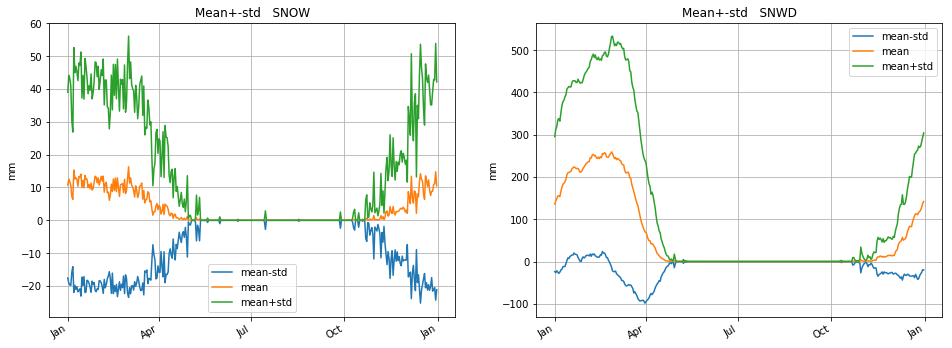

In [64]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)
savefig("mean_std_SNOW_SNWD.png",bbox_inches='tight')

### plotting top 3 eigenvectors

In [65]:
STAT['TMAX']['eigval'][:3]

array([ 58229.51434286,  27223.4613866 ,  26049.77663388])

In [66]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m, labels=labels)

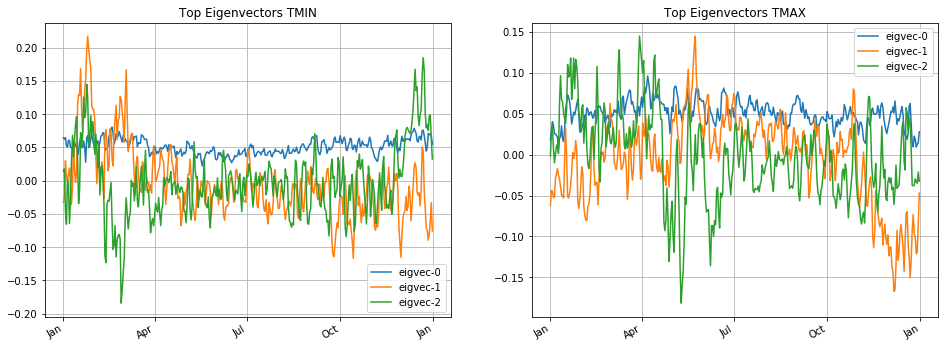

In [67]:
labels=['eigvec-0','eigvec-1','eigvec-2']
plot_pair(['TMIN','TMAX'],plot_eigen)
savefig("eigvec_TMIN_TMAX.png",bbox_inches='tight')

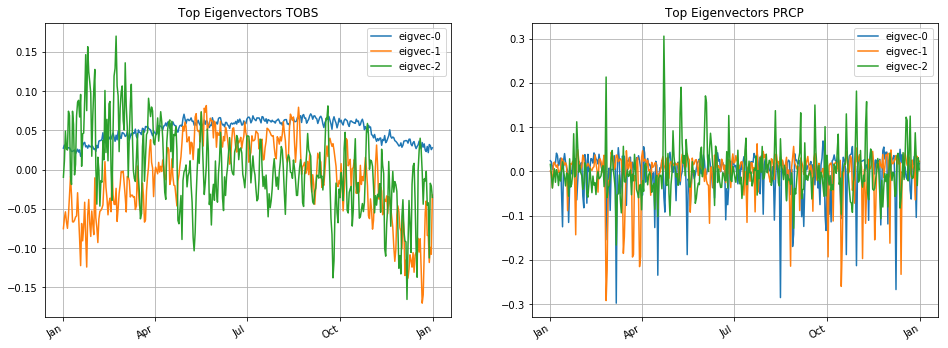

In [68]:
plot_pair(['TOBS','PRCP'],plot_eigen)
savefig("eigvec_TOBS_PRCP.png",bbox_inches='tight')

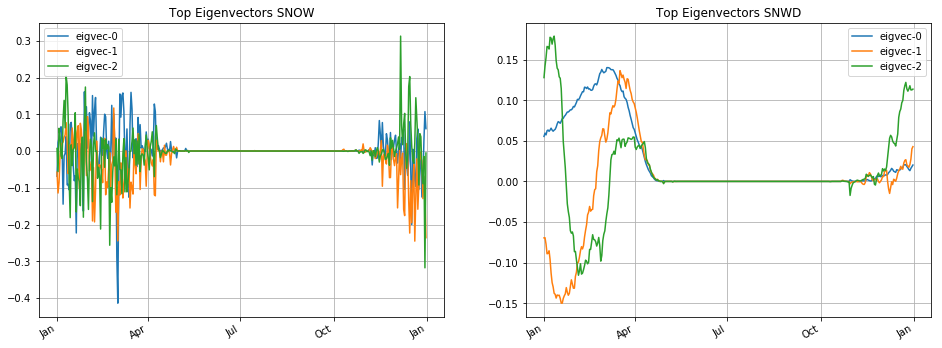

In [69]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)
savefig("eigvec_SNOW_SNWD.png",bbox_inches='tight')

### Script for plotting percentage of variance explained

In [70]:
def pltVarExplained(m,j,k):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    #k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

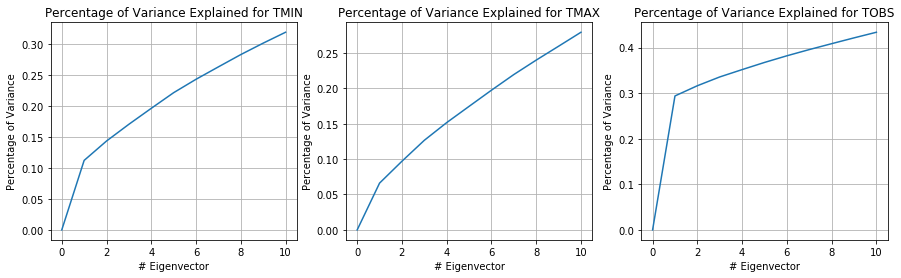

In [73]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN','TMAX','TOBS']: #,
    pltVarExplained(m,j,10)
    j+=1
savefig("var_expln_TMIN_TOBS_TMAX.png",bbox_inches='tight')

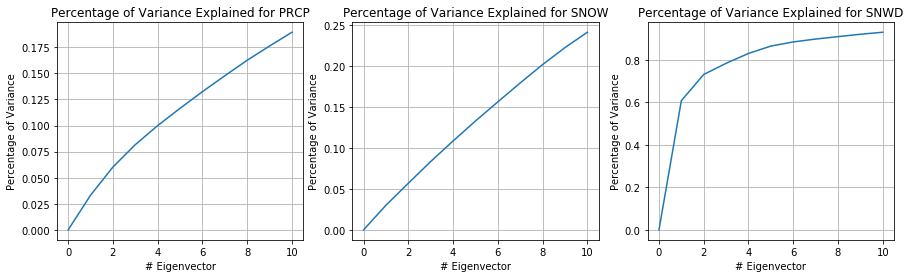

In [72]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['PRCP','SNOW', 'SNWD']:
    pltVarExplained(m,j,10)
    j+=1 
savefig("var_expln_PRCP_SNOW_SNWD.png",bbox_inches='tight')

In [23]:
#sc.stop()

In [12]:
from YearPlotter import YearPlotter
YP=YearPlotter()